# Querying FHIR with SQL 

FHIR data can be queried using SQL to create tabular views of the information stored on FHIR servers. However, these tables need to be manually curated to fill the tables with the information you required. For more information, see the relevant pages of the [documentation](https://docs.intersystems.com/irisforhealth20251/csp/docbook/DocBook.UI.Page.cls?KEY=HXFHIRFSB_installation).

## Setup

Before creating SQL views, we need to make sure the FHIR-SQL applications are enabled. To do this open the [management portal](http://localhost:8080/csp/sys/%25CSP.Portal.Home.zen) and go to:

    System Administration -> Security -> Applications -> Web Applications

Find `/csp/fhirsql` and `/csp/fhirsql/api/ui` and for each, click on the name to open the 'Edit Web Application' page and ensure that the `Enable Application` box is ticked. Remember to save the changes. 

## Creating SQL Analyses

To access FHIR data with SQL queries, we first need to create projections of the FHIR data in tabular form. This is done from the FHIR SQL BUILDER page, which is accessed at http://localhost:8080/csp/fhirsql/index.html#/home . 

First, we need to add out FHIR respository. On the panel on the left hand side, select 'Repository Configurations':


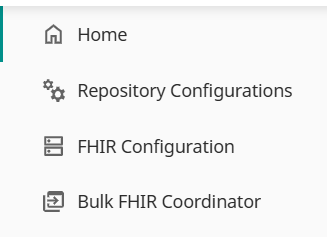

Click 'New' next to the FHIR Respository configurations panel.

To fill out the form:

- Name: SQLBuilderConfig (Or choose your own name)
- Host: localhost
- Port: 52773
- URL: Leave Blank
- SSL: Leave Blank
- Credentials:
    - Click new, create new credentials profile
        - Username: '_SYSTEM'
        - Password: 'SYS'

If you've filled this out correctly, when you click the 'FHIR Repository URL' dropdown, an option should appear. Select this option and click save. 


Now return to the SQL Builder homepage. 

Next to Analyses click new. Select your FHIR repository from the dropdown. Then enter 100 as the selectivity percentage. Click Launch Analysis Task. 


## Creating Transformation Specifications

Click New to create a new transformation specification. Give it a name, and choose to base it from the analysis Created in the previous step.

A transformation specification controls how your FHIR resources will be put into a table, i.e. which pieces of information within the FHIR data will be mapped into relational tables. 

On the left hand side, there is a list of FHIR resources that can be used. Each resource will include a number of pieces of data/information. 

![image.png](attachment:83d7e5dd-274a-49d5-82fe-adadde75bf45.png)

We can select the information we need from the resources. In this example, we are going to use DocumentReference data, so we want the following datapoints. Note, for each one you can change the column name for the output table. I am not going to bother doing this now, but you may consider doing so. 
For each of the following, make the change given and click 'Update' and/or 'Add to projection' at the bottom right of the right hand panel. 

    // This is the reference to the patient
    - DocumentReference -> Subject -> Reference
    
    // This is the encoded clinical note
    - DocumentReference -> Content -> Attachment -> Data 

    // Encounter date
    - DocumentReference -> Date

Also, we might want patient information later, so lets also add some patient details: 
    
    - Patient -> names -> family
    - Patient -> names -> given
    - Patient -> identifier -> value

When you are finished, click `Done` at the top right of the screen. 


## Create Projection 

Finally, you have to create a projection based on the specification you have made. This is as simple as picking the FHIR server and transformation specification we just created from the dropdown menus, then give it a name, this will be the base name for all of your tables. I have given the project the name: `VectorSearchApp`. 


## Querying the database

Now that we have created projections of our data, we can query it through SQL. The easiest method for this is to use the [Management Portal SQL Builder](http://localhost:32783/csp/sys/exp/%25CSP.UI.Portal.SQL.Home.zen). You may need to change the namespace to the FHIRSERVER namespace, this can be done from the top of the page: 



You can find the tables created in the list on the left hand side - if you've also called it VectorSearchApp it will be right at the bottom because its alphabetically ordered, drag the table into the `Execute Query` box to select all the comments.



## Querying the database with Python 

Now we know that the SQL works, we can query the database with Python. There are several different methods to execute SQL queries from Python, we are going to use the [Python DB-API method](https://docs.intersystems.com/irisforhealth20251/csp/docbook/Doc.View.cls?KEY=BPYNAT_pyapi), as it is the prefered method for using relational querying from a Python Application. This uses the `intersystems-irispython`, which can be installed with pip:

    pip install intersystems-irispython==5.1.0 

(Note, I've had some issues with the most recent version of this driver, so I am specifying version 5.1.0 to ensure consistent results.) 

To use this method we take the following steps: 

    1. Create a connection
    2. Create a Cursor object
    3. Create the SQL query (and parameters) 
    4. Execute the query from the cursor object
    5. Iterate through the results from the cursor object. 
    6. Extract the results into a pandas DataFrame

Here, its important to note that the cursor execution command does not directly return the results, instead the results are stored within the cursor object.

### Create Connection and Cursor

In [1]:
## Import IRIS python DB-API Driver
import iris

In [3]:
## Credentials: 
server_location = "localhost"
port_number = 32782
namespace = "DEMO"
user_name = "_SYSTEM"
password = "ISCDEMO"

## Create a connection
conn = iris.connect(server_location, port_number, namespace, user_name, password)

## Create a cursor object
cursor = conn.cursor()

### Create SQL query

There are two options here, we can either create a single query string containing all the search parameters, or we can leave out some parameters to be defined at the point of execution, leaving a '?' character as a placeholder. 

For example, we could run:

    cursor.execute("SELECT col1, col2 FROM exampleTable") 

or we could run:

    cursor.execute("SELECT ?, ? FROM exampleTable", ["col1", "col2"])

These options have the same result, but the second option allows different parameters to be passed into the same query. You can even execute the query with a list of parameter lists using the `cursor.executemany()` command. This functionality is particularly useful when inserting new data into tables. 

For now though, we are going to execute the query I gave above using the syntax from the first example:

In [4]:
sql = """SELECT 
DocumentReferenceContentAttachmentData, DocumentReferenceSubjectReference
FROM VectorSearchApp.DocumentReference"""

In [5]:
cursor.execute(sql)

-1

### Extracting Data

While the result of the query above (-1) may suggest failure, here it actually means the query has been executed successfully. The results can be collected from the cursor object using one of the following commands: 

- `cursor.fetchone()` returns the next row of data from the query.
- `cursor.fetchmany(n)` returns the next n rows of data (where n is an integer). 
- `cursor.fetchall()` returns all the results. 

You can find more specific and useful methods in the [DB-API documentation](https://docs.intersystems.com/irisforhealth20251/csp/docbook/Doc.View.cls?KEY=BPYNAT_pyapi)

We are going to use `cursor.fetchall()` and collect it in a pandas DataFrame. 


In [6]:
result_set = cursor.fetchall()

In [7]:
import pandas as pd
## The result_set doesn't include column names so we will add them ourselvs
cols = ["ClinicalNotes", "Patient"] 

df = pd.DataFrame(result_set, columns=cols)

In [8]:
df.head()

,ClinicalNotes,Patient
0,4f7469746973204d65646961204576616c756174696f6e...,Patient/3
1,446174653a20323032352d30382d30360a50726f766964...,Patient/3
2,466f6c6c6f772d557020666f72204f7469746973204d65...,Patient/3
3,446174653a20323032342d31312d32310a50726f766964...,Patient/3
4,446174653a20323032342d30382d30360a50726f766964...,Patient/3


In [9]:
print(len(df))

51


In [10]:
df["PatientID"] = pd.to_numeric(df["Patient"].astype(str).str.strip("Patient/"))

df.head()

,ClinicalNotes,Patient,PatientID
0,4f7469746973204d65646961204576616c756174696f6e...,Patient/3,3
1,446174653a20323032352d30382d30360a50726f766964...,Patient/3,3
2,466f6c6c6f772d557020666f72204f7469746973204d65...,Patient/3,3
3,446174653a20323032342d31312d32310a50726f766964...,Patient/3,3
4,446174653a20323032342d30382d30360a50726f766964...,Patient/3,3
